<img src="virgo_logo.png" alt="Title" style="width:300px;"/>

# Virgo Gravitational Wave Data Exercise

The aim of the exercise is to prepare a ML tool which is able to compress and clean as much as possible a dataset.

**The autoencoder coded in this exercise is only used as an opportunity to acquire some insight into ML** 

In this exercise you will:

- explore the content of a dataset from the **International Gravitational-Wave Observatory Network** containing the strain as a function of time;
- try to plot quantities and understand which features could help in separating signal from noise;
- train a network in order to perform the job, and test their abilities.


## Gravitational Wave Data

For an introduction on what GW and interferometers are please refer to https://confluence.infn.it/display/MLINFN/7.+Virgo+Autoencoder+tutorial

For a brief vocabulary see https://labcit.ligo.caltech.edu/~ll_news/0607a_news/LIGO_Vocabulary.htm

**IGWN** stands for International Gravitational-Wave Observatory Network, it is a comunity made by three collaborations: LIGO VIRGO and KAGRA 

**Strain** is the instrument’s ability to detect a space change within an arm in comparison to the total space (length) of the arm

**GWF** stands for Gravitational Wave File and is the format IGWN used to store (not only!) interferometer strain

All data we will use in this tutorial is freely accessibile and published by **GWOSC** (https://www.gw-openscience.org/about/). GWOSC, The Gravitational Wave Open Science Center, provides data from gravitational-wave observatories, along with tutorials and software tools. You could find there many information if you are interested

## Data Access

To ease the reading and decoding of the data file we will rely on a python package named `gwdama` that needs to be imported (and installed because not available by default on the system)

*gwdama* (https://pypi.org/project/gwdama/) aims at providing a unified and easy to use interface to access Gravitational Wave (GW) data and output some well organised datasets, ready to be used for Machine Learning projects or Data Analysis purposes (source properties, noise studies, etc.)

In [1]:
#maybe needed, do it only if you have an error like "No module named 'gwdama'"" below
!pip install gwdama

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [20]:
from gwdama.io import GwDataManager
import numpy as np
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

Datasets made available through the gwdama interface are organized by time and detector. Each data entry includes the strain recorded by the detector as a function of time. Datasets can be selected by indicating a time range and the detector, for this exercise we will select events in the gps time range 118674… corresponding to signal events acquired in April 2020

Observing run, generally called O with a number to distinguish between many of them (for example **O3**), are our scientific and acquisition runs

**gps time** is a timestamp relative to an arbitrarly event (6 January 1980), internally we use our tools to convert to usual epoch time

At https://www.gw-openscience.org/events/ you could find a list of events with their gps time and a brief description of the results

Let's get data between two gps 1186746568 and 1186746628 from GWOSC (default).  You can specify a name for the dataset that you are imposting passing the parameter `dts_key`. 

In [21]:
event_gps = 1186746618  
dm = GwDataManager("data")
dm.read_gwdata(event_gps - 50, event_gps +10, ifo='L1')

In [22]:
print(dm)

data:
  └── strain

  Attributes:
     dama_name : data
    time_stamp : 21-06-03_11h52m06s



data acquisition is 21-04-21_10h50m25s.
To acquire some confidence with data we will start with a plot

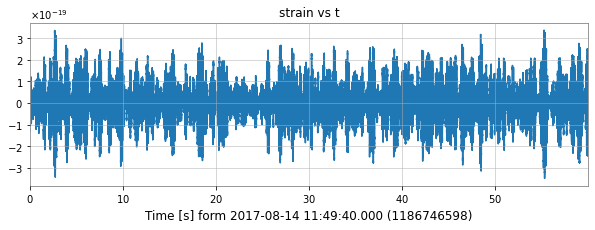

In [23]:
online=dm['strain']

# time vs strain
# to make plot more nice add some properties, they will be addedd to the figure
online.attrs['t0'] = 1186746598
online.attrs['sample_rate'] = 4096   # Unit Hz
online.attrs['unit'] = ""
online.attrs['channel'] = "strain vs t"

online.plot()

**Remember**: here the timestamp is different because internally in the IGWN we use a different convention

**Exercise**: read multiple files and plot them with a single for loop

As a pretext to show some functions in gwdama, we will make a histogram of strain and fit with a Gaussian

**norm** is a class of scipy to work with a normal distribution (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html). In this case we will use the fit method to estimate mean and standard deviation of the input signal. If a **gw** is not present then we can assume for the scope of this exercise that the signal is normal distribute (*which is not in real life!*) 

In [24]:
myplot = online.hist()
mu, std = norm.fit(online.data)

Customize the plot, adding the fitted Gaussian and a legend

**gca** method gets the current Axes, creating one if necessary

**get_xlim** return min and max value on the x axis

**linspace** return evenly spaced number in an interval

**pdf** return a probability density function (see norm before)

**plot** plot x,y data. 'r--' is used to control the line style (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) 

**legend** add a legend to the plot

**show** is used to show the plot

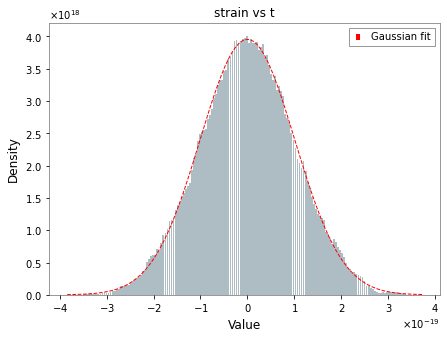

In [25]:
ax = myplot.gca()
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'r--', linewidth=1, label='Gaussian fit')
ax.legend()

myplot.reshow()                    # New method to re-show closed figures

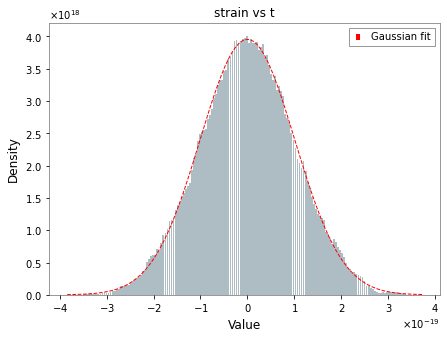

In [26]:
myplot

To obtain more information from the dataset it is customary to study its "Power Spectral Density" (PSD) [https://en.wikipedia.org/wiki/Spectral_density] which is related to the Fourier Transform of the squared signal and measure the signal’s power content versus frequency. A PSD is typically used to characterize broadband random signals. To define the PSD we must define a grid on which we compute the Discrete Fourier Transform, the number of elements of the grid is named “sample_rate” in gwdama

Create a **PSD** with sample rate 4096 Hz

In [27]:
fs = 4096
online.attrs['sample_rate'] = fs
online.psd(2,1)

<HDF5 dataset "strain_psd": shape (4097,), type "|V16">

In [29]:
print(dm)

data:
  ├── strain
  └── strain_psd

  Attributes:
     dama_name : data
    time_stamp : 21-06-03_11h52m06s



The psd is added to our dataset and named ${name}_psd, *name* in this case in "online"

Now let's plot the PSD

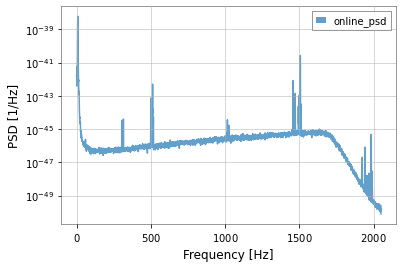

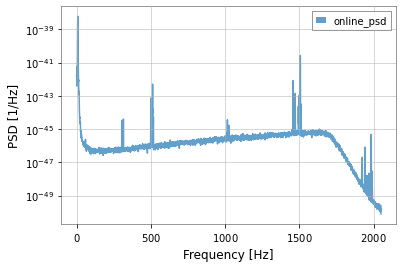

In [33]:
online_psd=dm['strain_psd']
fig, ax = plt.subplots()
ax.semilogy('freq', 'PSD', data=online_psd, alpha=.7, label='online_psd')

ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [1/Hz]')
plt.show()
fig


We generally work with signals normalized to their spectral density through an operation named *whitening*

A **whitned** signal is a normalized signal to its spectral density. To compute it you should get in the freq domain, divide it by the square roots of the power spectral density and return to time domain

For convenience gwdama provides a simple function that whiten the signal: output=whiten(input, input_psd, freq)
or dama['name'].whiten() and the output will be dama['name_whiten']

In [35]:
dm['strain'].whiten()

<HDF5 dataset "strain_whiten": shape (245760,), type "<f8">

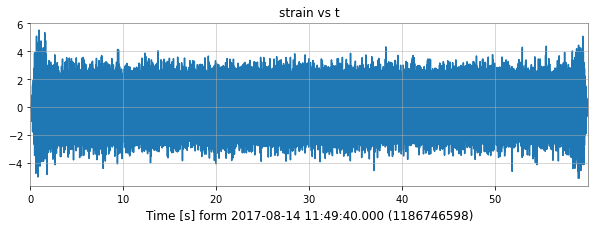

In [36]:
# let's plot it
dm['strain_whiten'].plot()

This data is sampled at 4096 Hz, but our interferometers acts like a pass band signal from a frequency ~ between 20-400Hz so it could be usefull to resample the data in order to work with lighter files and remove some noise

**decimate_recursive** resamples an input signal keeping only 1 elem every n

**resample** resamples an inpunt signal to a dest freq. We will use in this case 512 so we are keeping only 1 every 8 values being our original signal sampled at 4096

In [37]:
print(dm)

data:
  ├── strain
  ├── strain_psd
  └── strain_whiten

  Attributes:
     dama_name : data
    time_stamp : 21-06-03_11h52m06s



In [38]:
dm['strain_whiten'].resample(512)

<HDF5 dataset "strain_whiten_r512": shape (30720,), type "<f8">

In [39]:
print(dm)
# gwdama could return an error, because you are rewriting an already existing entry 
# this happens for example if you re-run twice a cell. Solution is easy, just delete the old entry
# You can delete an entry with
#del dama["online_whiten_r10"]

data:
  ├── strain
  ├── strain_psd
  ├── strain_whiten
  └── strain_whiten_r512

  Attributes:
     dama_name : data
    time_stamp : 21-06-03_11h52m06s



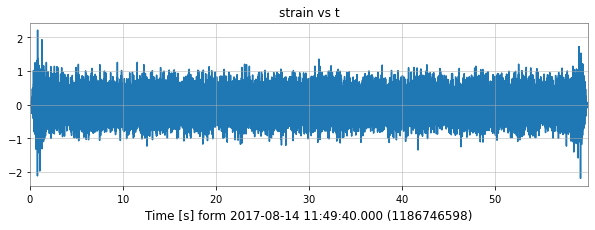

In [40]:
# let's plot it
dm['strain_whiten_r512'].plot()

Just for fun try to resample at 128 256 1024 too

In [42]:
dm['strain_whiten'].resample(128)
dm['strain_whiten'].resample(256)
dm['strain_whiten'].resample(1024)

<HDF5 dataset "strain_whiten_r1024": shape (61440,), type "<f8">

If you prefer to work directly with the usual list/array of values, simply get them with:
values= dama[name_record].data 
times = dama[name_record].times

**Remark**: Through all exercises, we will assume a constant sample_rate with fixed lentgh of chunks

if you want to get more information on data and the cleaning process here a usefull link https://github.com/losc-tutorial/Data_Guide/blob/master/Guide_Notebook.ipynb

Once data is ready we can try to encode with an **autoencoder**

[from wiki]: An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learned, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name

some examples of autoencoders in keras at https://blog.keras.io/building-autoencoders-in-keras.html

The idea is to encoding and decoding to original dimension searching for an optimum set of parameters that makes filtered signal more similar to original one. The encoded signal will retain all needed information but with a reduction of size

To make our statement more concise we will summary some ideas on Artificial Neural Networks and Deep Learning

## Artificial Neural networks 

**Artificial neural networks (ANNs)** are computing systems vaguely inspired by the biological neural networks that constitute animal brains.

An ANN is based on a collection of connected units or nodes called artificial neurons, which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal to other neurons. An artificial neuron that receives a signal then processes it and can signal neurons connected to it. The "signal" at a connection is a real number, and the output of each neuron is computed by some non-linear function of the sum of its inputs. The connections are called edges. Neurons and edges typically have a weight that adjusts as learning proceeds. The weight increases or decreases the strength of the signal at a connection. Neurons may have a threshold such that a signal is sent only if the aggregate signal crosses that threshold. Typically, neurons are aggregated into layers. Different layers may perform different transformations on their inputs. Signals travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple time and along different paths

Artificial networks could be build by many layers, each one connected to each others. There are amny types of networks. For example:

A **feedforward neural network** is an artificial neural network wherein connections between nodes do not form a cycle, layers are connected starting from the top (input) to the bottom (output) and the activation flows from top to the end exclusively

A **recurrent neural network (RNN)** is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs. Typically part of output of one layer is feed as input to the same layer at a different time

[https://en.wikipedia.org/wiki/Artificial_neural_network]

## Layers

**Layers** are group of nodes that mimic some concepts. Each node inside the layer shares same input and output and the same activation function

## Activation function

The **activation function** of a node defines the output of that node given an input or set of inputs. Experience shows that only nonlinear activation functions allow networks to compute nontrivial problems using only small number of nodes

- **rectifier or ReLU** activation function is an activation function defined as the positive part of its argument

- **Sigmoid** activation function is an activation function which applies a sigmoid to the input. The assumption here is that we are interested in intermediate value of input, so we treat them in a liner way, greater values in modulo are not so important because are extreme and show fewer variation

[ https://en.wikipedia.org/wiki/Activation_function ]

## Loss function
Loss is nothing but a prediction error of Neural Network. And the method to calculate the loss is called Loss Function. The output of keras contains two similar terms, val_loss and loss. *val_loss is the value of cost function for your cross-validation data and loss is the value of cost function for your training data.*

## Optimizer

The **optimizer** is used to explorer the parameters space searching which value correspond to a minimum value of the loss function

## Learning 

**Supervised learning** is the machine learning task of learning a function that maps an input to an output based on example input-output pairs

**Unsupervised learning** is the task of learning a function that maps an input to an output based on some cost function

## Overfitting

Overfitting is a modeling error in statistics that occurs when a function is too closely aligned to a limited set of data points. Overfitting the model generally takes the form of making an overly complex model to explain idiosyncrasies in the data under study

## Regularization

Regularization in machine learning is the process of regularizing the parameters that constrain, regularizes, or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, reducing the risk of Overfitting

## Restatement of the task

An autoencoder has an input layer, an output layer and one or more hidden layers connecting them. The output layer has the same number of units as the input layer. Its purpose is to reconstruct its own inputs. Therefore, autoencoders are unsupervised learning models. We want our autoencoder to efficient encodes using unsupervised learning

**Question**: Could an autoencoder have in total only a single layer? Two layers? Three?

**Remark**:The loss function is used to optimize your model. This is the function that will get minimized by the optimizer. A metric is used to judge the performance of your model!

We will use keras ( https://keras.io/ )
"Keras is an API designed for human beings, not machines. Keras follows best practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes the number of user actions required for common use cases, and it provides clear & actionable error messages. It also has extensive documentation and developer guides."

Some usefull info:

- https://blog.keras.io/building-autoencoders-in-keras.html

- https://keras.io/api/models/

In the following we will use a slightly different approch from usual, instead of using a single command, we use sklearn as interface to call other functions. The idea is to learn to wrap Keras models for use in scikit-learn and how to use grid search. "GridSearchCV is a library function that is a member of sklearn's model_selection package. It helps *to loop through predefined hyperparameters* and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters" 

Please **Remember**: Keras is a high-level API built on Tensorflow. Scikit Learn is a general machine learning library built on top of NumPy

[https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html ] 

[https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ ]

Some layers used in keras:

- **Dense** layer makes output=activation(dot(input, kernel) + bias) where kernel is the matrix of parameters and activation is the activation function. Each node is fed by the whole input! 

- **Dropout** layer randomly sets input units to 0 with a frequency of rate at each step during training time. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged

*Please remember, before process data with machine learning tecniques it is really important to normalize and resample at a fixed rate all the data. That's why we explained in the introduction how to do it*

## Starter Example
write an autoencoder with keras only that takes as input a 1D signal

In [43]:
import keras
from keras import layers
from keras.utils.vis_utils import plot_model

# This is the size of our encoded representations
original_dim = 128
encoding_dim = 32  # 32 floats -> compression of factor 4.0, assuming the input is 128 floats

# This is our input image
input_signal = keras.Input(shape=(original_dim,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_signal)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(original_dim, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_signal, decoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# for fun, let's create a random input signal() mean=0 std=3) of 128*1000 elements. Why it is multiple of 128?
noise = np.random.normal(0, 3, original_dim*1000)

# a 2d-array of shape x=original_dim, y=100
x_signal = np.stack(np.split(noise,1000))
x_signal.shape

# first 90 rows to use as train
x_train=x_signal[0:900,:]
#last 10 rows to use as test
x_test = x_signal[900:,:]

# encode with a batch of 50 rows (how many iterations?) for 15 times...
autoencoder.fit(x_train, x_train, epochs=15, batch_size=30, shuffle=True, validation_data=(x_test, x_test))

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_25 (Dense)             (None, 128)               4224      
Total params: 8,352
Trainable params: 8,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
30/30 [==============================] - 1s 11ms/step - loss: 9.4118 - val_loss: 9.2170
Epoch 2/15
30/30 [==============================] - 0s 5ms/step - loss: 9.1084 - val_loss: 9.0740
Epoch 3/15
30/30 [==============================] - 0s 6ms/step - loss: 9.0042 - val_loss: 8.9753
Epoch 4/15
30/30 [==============================] - 0s 5ms/step - loss: 8.8534 - val_loss: 8

## Starter example II
add some layers for fun and acquire some confidence with keras

the workflow will be the following
original -> encoded size 32 -> convolution -> encoded size 16 -> decoded size 32 -> decoded size original

it is convenient to play a bit with layers that expect a different number of dimension in this case

Conv1D expects a 3d signal, for this reason we will add a singleton dimension doing

*shape=(original_dim,1,)*

please note the "1" added to the list of the dimension

In [44]:
import keras
from keras import layers

# This is the size of our encoded representations
original_dim = 128
encoding_dim = 32  # 32 floats -> compression of factor 4.0, assuming the input is 128 floats
encoding_dim_1 = 16  # 16 floats -> compression of factor 8.0, assuming the input is 128 floats

# This is our input image
input_signal = keras.Input(shape=(1,original_dim))
# "encoded" is the encoded representation of the input
convolved = layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation='relu', input_shape=(1,original_dim))(input_signal)
encoded = layers.Dense(encoding_dim, activation='relu')(convolved)
encoded_1 = layers.Dense(encoding_dim_1, activation='relu')(encoded)
# "decoded" is the lossy reconstruction of the input
decoded_1 = layers.Dense(encoding_dim, activation='sigmoid')(encoded_1)
decoded = layers.Dense(original_dim, activation='sigmoid')(decoded_1)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_signal, decoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# for fun, let's create a random input signal() mean=0 std=3) of 128*1000 elements. Why it is multiple of 128?
noise = np.random.normal(0, 3, original_dim*1000)

# reshape to fit data
# process the data to fit in a keras CNN properly
# input data needs to be (N, C, X, Y) - shaped where
# N - number of samples
# C - singleton dimension
# (X, Y) - sample size

X_signal = noise.reshape((1000, 1, original_dim, 1))
x_train = X_signal[0:900,:,:,:]
x_test = X_signal[900:,:,:,:]
# encode with a batch of 50 rows (how many iterations?) for 15 times...
autoencoder.fit(x_train, x_train, epochs=15, batch_size=30, shuffle=True, validation_data=(x_test, x_test))
X_signal.shape

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 128)]          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 64)             24640     
_________________________________________________________________
dense_26 (Dense)             (None, 1, 32)             2080      
_________________________________________________________________
dense_27 (Dense)             (None, 1, 16)             528       
_________________________________________________________________
dense_28 (Dense)             (None, 1, 32)             544       
_________________________________________________________________
dense_29 (Dense)             (None, 1, 128)            4224      
Total params: 32,016
Trainable params: 32,016
Non-trainable params: 0
_______________________________________________________

(1000, 1, 128, 1)

Sometime you need to see what an intermediate layer is doing,

here a simple skeleton, get a list of all layers used, create a keras function with two input parameters [input, learning_phase()] and [single_layer]...then call it with data


inp = autoencoder.input                                           # input placeholder
outputs = [layer.output for layer in autoencoder.layers]          # all layer outputs
functors = [keras.function([inp, keras.learning_phase()], [out]) for out in outputs]    # evaluation functions

Testing
test = np.random.random(input_shape)[np.newaxis,...]
layer_outs = [func([test, 1.]) for func in functors]
print layer_outs

## Starter example III

Now we will try do denoise a simple sin wave using an autoencoder, the idea is that noise is small (and higher freqs) compared to signal. 

Autoencoding remove some data, maybe it could remove part of noise in this very simple case...

Here you could see what's happen if! Feel free to change parameters like offset signal, num_array, interval, epochs and so on

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1, 629)]          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1, 314)            592832    
_________________________________________________________________
dense_46 (Dense)             (None, 1, 314)            98910     
_________________________________________________________________
dense_47 (Dense)             (None, 1, 31)             9765      
_________________________________________________________________
dense_48 (Dense)             (None, 1, 314)            10048     
_________________________________________________________________
dense_49 (Dense)             (None, 1, 629)            198135    
Total params: 909,690
Trainable params: 909,690
Non-trainable params: 0
____________________________________________________

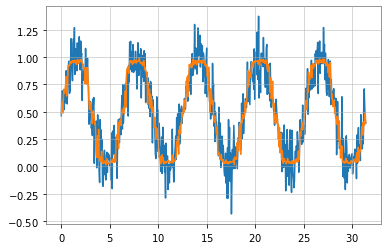

In [50]:
def gen_time(tmin=0,tmax=np.pi*10,step=0.05):
    time = np.arange(tmin, tmax, step)
    return time, len(time)

def gen_signal(time, amp=1):
    # Amplitude of the sine wave is sine of a variable like time.
    amplitude = amp* np.sin(time)
    return amplitude

def gen_noise(npoints=1000, sigma=3, mean=0, amplitude=0.1):
    noise = amplitude * np.random.normal(mean, sigma, npoints)
    return noise

def gen_signal_array(time, amp_signal, amp_noise, sigma, mean, nelems=1000, offset=0):
    npoints = len(time)
    arr = np.array([])
    for el in range(0,nelems):
        signal = gen_signal(time, amp_signal) + offset
        noise = gen_noise(npoints, sigma, mean, amp_noise)
        wave = signal + noise
        arr = np.concatenate((arr, wave))
    return arr

time, npoints = gen_time()

# This is the size of our encoded representations
original_dim = npoints
encoding_dim = npoints/2  
encoding_dim_1 = npoints/20
num_array = 10

arr = gen_signal_array(time, amp_signal=0.5, amp_noise=0.05, sigma=3, mean=0, nelems=num_array, offset=0.5)

# reshape to fit data
# process the data to fit in a keras CNN properly
# input data needs to be (N, C, X, Y) - shaped where
# N - number of samples
# C - singleton dimension
# (X, Y) - sample size

X_signal = arr.reshape((num_array, 1, original_dim, 1))
x_train = X_signal[0:round(0.9*num_array),:,:,:]
if round(0.9*num_array) == num_array:
    x_test = x_train
else:
    x_test = X_signal[round(0.9*num_array):,:,:,:]

def autoencoder_func(x_train, x_test, epochs=150):
    # This is our input image
    input_signal = keras.Input(shape=(1,original_dim))
    # "encoded" is the encoded representation of the input
    convolved = layers.Conv1D(filters=314, kernel_size=3, strides=1, padding="causal", activation='relu', input_shape=(1,original_dim))(input_signal)
    encoded = layers.Dense(encoding_dim, activation='relu')(convolved)
    encoded_1 = layers.Dense(encoding_dim_1, activation='relu')(encoded)
    # "decoded" is the lossy reconstruction of the input
    decoded_1 = layers.Dense(encoding_dim, activation='sigmoid')(encoded_1)
    decoded = layers.Dense(original_dim, activation='sigmoid')(decoded_1)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_signal, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    history = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=10, shuffle=True, validation_data=(x_test, x_test))
    decoded = autoencoder.predict(x_test)
    return history, decoded, autoencoder

history, decoded, model = autoencoder_func(x_train, x_test, epochs=20)

# plot results
plt.plot(time, x_train[0,:,:].reshape(len(time),1))
plt.plot(time, decoded[0,:,:].reshape(len(time),1))
plt.show()


**Query**: Sometimes the decoded signal get clamped, are you able to understand why?

**Query2**: Do you remember the difference between loss and val_loss?

**Task**: Are you able to make a plot of loss vs epochs?

**Query3**: The training time increase/decrease when changing the batch_size? and how about the loss?

draw the model!!!

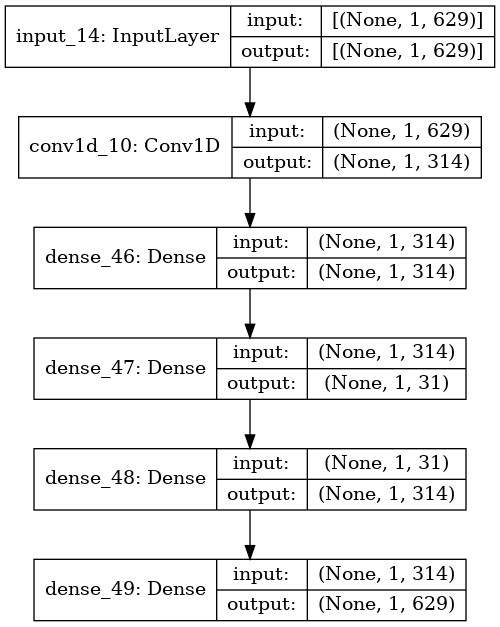

In [51]:
plot_model(model, show_shapes=True, show_layer_names=True)

**Remark** There are many parameters, you have to chose them to obtain the minimum of val_loss/loss

It is a matter of chosing the right parameters, and you have to explore them, that's why we introduce a grid search

That's function is in sklearn, let's jump straight to the next example

## Simple example
in this example we will use different api from the one used before, it is easy to change between one format and the other

A skeleton autoencoder will take input, import relevant functions, define a model, optimize it and test it

Let's start!

In [52]:
# input
# we will split our data in chunk of n elements and we will feeds our network with all these chunks
n_features = 100 # is the size of a single chunk of data
n_encoded = n_features

# add a normal dataset to dama
dm.create_dataset('random_n', data=np.random.normal(0, 1, (10000,)))

# access its data and store in variable input_data
input_data = dm['random_n'].data

# split data in chunks of 100 element each one and stack each chunk vertically
chunks = np.stack(np.split(input_data,100))
chunks.shape

(100, 100)

In [53]:
import math

from keras import optimizers
from keras.optimizers import Nadam

from keras import regularizers

from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, TimeDistributed

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

import joblib

In [54]:
# a very simple model, feedforward neural network with two layers and with two different activation functions
def baseline_model(bias1=1e-9, bias2=1e-9, ker1=1e-9, ker2=1e-9):
  
    model = Sequential()
    model.add(Dense(n_features, activation='sigmoid', input_shape=(n_features,), bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model.add(Dense(n_encoded, activation='relu', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))

    model.compile(optimizer=Nadam(lr=5e-6), loss='mse', metrics=['mse'])

    return model

We had defined a function (with four parameters!) that build a very minimalistic model

**Sequential** initialize the model

**add** method is used to add layers to your model

**compile** method id used to configure the model for training https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile

some reference to its parameters:
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/api_docs/python/tf/keras/losses
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric

You could get usefull debugging message with **model.summary()**

In [55]:
# machine learning
# epochs is used for recurrent networks, we don't need them so we set to 1
# batch_size is the number of input chunks
#mlp = KerasRegressor(build_fn=baseline_model, epochs=1, batch_size=n_features, verbose=0)
mlp = KerasRegressor(build_fn=baseline_model, verbose=0)

**KerasRegressor** is a wrapper to use keras from sklearn. It takes as parameters, your function model, epochs, batch size. See for example https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor

The **batch size** is a hyperparameter that defines the number of samples to work through before updating the internal model parameters

The number of **epochs** is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. See for example https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [56]:
# space of parameters used when call our model, only one value for each....
# in the next example we will use a dictionary like the following, trying to search on parameters that regularise the network
# param_distr = dict(bias1 = [1e-9], bias2 = [1e-9], ker2 = [1e-9], ker1 = [1e-9])
param_distr = dict(epochs=[1], batch_size=[n_features])

param_distr is a dictionary of parameters to try, we will explore on all combinations
**Query**: How many combinations will have in a general case? In this case?

In [57]:
# build our model all together
grid_search = GridSearchCV(estimator=mlp, param_grid=param_distr, cv=3)

**GridSearchCV** Exhaustive search over specified parameter values for an estimator. So we are trying all combinations! https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In particular: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.fit

X: array-like of shape (n_samples, n_features)

In [58]:
# fit it
# vay all nodes based on param_distr to make output "near" to input. Near here mean output of a distance function 'mse' 
grid_search.fit(chunks, chunks)

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7ff02c654c88>,
             param_grid={'batch_size': [100], 'epochs': [1]})

In [59]:
# get some info
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means  = grid_search.cv_results_['mean_test_score']
stds   = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

Best: -1.162755 using {'batch_size': 100, 'epochs': 1}


**Question**: Is output data only positive? why?

## Exercise 1: Alter model changing activation functions

Redo all steps but in the model function use a different activation function

In [60]:
# a very simple model, feedforward neural network with two layers and with two different activation functions
def baseline_model1(bias1=1e-9, bias2=1e-9, ker1=1e-9, ker2=1e-9):
  
    model1 = Sequential()
    model1.add(Dense(n_features, activation='relu', input_shape=(n_features,), bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model1.add(Dense(n_features, activation='sigmoid', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))

    model1.compile(optimizer=Nadam(lr=5e-6), loss='mse', metrics=['mse'])

    return model1


mlp1 = KerasRegressor(build_fn=baseline_model1, epochs=1, batch_size=n_features, verbose=0)
param_distr1 = dict(bias1 = [1e-9], bias2 = [1e-9], ker2 = [1e-9], ker1 = [1e-9])
grid_search1 = GridSearchCV(estimator=mlp1, param_grid=param_distr1, cv=3)
grid_search1.fit(chunks, chunks)
print("Best: %f using %s" % (grid_search1.best_score_, grid_search.best_params_))
means  = grid_search1.cv_results_['mean_test_score']
stds   = grid_search1.cv_results_['std_test_score']
params = grid_search1.cv_results_['params']

Best: -1.307258 using {'batch_size': 100, 'epochs': 1}


## Exercise 2: example with real data

We need to follow exactly what we did before but using our gw data insetad of our simulated data

Recall that to get data from dama you could use "dama['random_n'].data" 

In real life before start we will have to decide what will be
- our chunk size
- our metric

using frequency and other values as starting point

We can however start with an (nearly!) arbitrary value and see what will happen



In [62]:
print(dm['strain_whiten_r512'])
input_data=np.array(dm['strain_whiten_r512'].data)
input_data.shape

<HDF5 dataset "strain_whiten_r512": shape (30720,), type "<f8">


(30720,)

get a number of point mutiple of 100, for example we will use first 49 * 100 elems

In [63]:
input_data[0:4900].shape

(4900,)

In [64]:
chunks = np.stack(np.split(input_data[0:4900],100))
chunks.shape

(100, 49)

as already said, we have an array-like of shape (n_samples, n_features)
so here we have 49 features in 100 samples

We can now proceed as usual

In [65]:
n_features=49

# a very simple model, feedforward neural network with two layers and with two different activation functions
def baseline_model2(bias1=1e-9, bias2=1e-9, ker1=1e-9, ker2=1e-9):
  
    model2 = Sequential()
    model2.add(Dense(n_features, activation='relu', input_shape=(n_features,), bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model2.add(Dense(n_features, activation='sigmoid', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))

    model2.compile(optimizer=Nadam(lr=5e-6), loss='mse', metrics=['mse'])

    return model2


mlp2 = KerasRegressor(build_fn=baseline_model2, epochs=100, batch_size=10, verbose=0)
param_distr2 = dict(bias1 = [1e-9], bias2 = [1e-9], ker2 = [1e-9], ker1 = [1e-9])
grid_search2 = GridSearchCV(estimator=mlp2, param_grid=param_distr2, cv=3)
grid_search2.fit(chunks, chunks)
print("Best: %f using %s" % (grid_search2.best_score_, grid_search2.best_params_))
means  = grid_search2.cv_results_['mean_test_score']
stds   = grid_search2.cv_results_['std_test_score']
params = grid_search2.cv_results_['params']

Best: -0.390438 using {'bias1': 1e-09, 'bias2': 1e-09, 'ker1': 1e-09, 'ker2': 1e-09}


**Note**: Could you alter code to have 49 elems(samples) of 100 features each one?

## Exercise 3: Alter model, adding a dropout layer and a new dense layer

Let's make a complex example, adding a new dense layer(s), a droput layer and asking for a compression factor of 4 times

Dropout in this case help in reduce the number of neurons, in order to avoid the problem of "sleeping neurons" but it is really here as a placeholder, you could add a convolution layer for fun if you want

In [66]:
n_features=49
dropout=0.1

# a very simple model, feedforward neural network with two layers and with two different activation functions
def baseline_model3(bias1=1e-9, bias2=1e-9, ker1=1e-9, ker2=1e-9):
  
    model3 = Sequential()
    
    model3.add(Dense(n_features, activation='relu', input_shape=(n_features,), bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model3.add(Dropout(dropout))
    model3.add(Dense(int(n_features/2), activation='relu', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model3.add(Dropout(dropout))
    model3.add(Dense(int(n_features/4), activation='relu', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model3.add(Dropout(dropout))

    model3.add(Dense(int(n_features/4), activation='sigmoid', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model3.add(Dense(int(n_features/2), activation='sigmoid', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    model3.add(Dense(n_features, activation='sigmoid', bias_regularizer=regularizers.l1_l2(l1=bias1, l2=bias2), kernel_regularizer=regularizers.l1_l2(l1=ker1, l2=ker2)))
    
    model3.compile(optimizer=Nadam(lr=5e-6), loss='mse', metrics=['mse'])

    return model3


mlp3 = KerasRegressor(build_fn=baseline_model3, epochs=1, batch_size=100, verbose=0)
param_distr3 = dict(bias1 = [1e-9], bias2 = [1e-9], ker2 = [1e-9], ker1 = [1e-9])
grid_search3 = GridSearchCV(estimator=mlp3, param_grid=param_distr3, cv=3)
grid_search3.fit(chunks, chunks)
print("Best: %f using %s" % (grid_search3.best_score_, grid_search3.best_params_))
means  = grid_search3.cv_results_['mean_test_score']
stds   = grid_search3.cv_results_['std_test_score']
params = grid_search3.cv_results_['params']

Best: -0.409439 using {'bias1': 1e-09, 'bias2': 1e-09, 'ker1': 1e-09, 'ker2': 1e-09}


We altered number of neurons, is metric better or worse compare to other exercise? was expected?

## Exercise 4: Tune parameters

**Add to param_distr both Batch size and Epochs, retrain and take best values**

...same model as before...

batch_size = [10, 20, 40, 60, 80, 100]

epochs = [10, 50, 100]

param_distr = dict(bias1 = [1e-9], bias2 = [1e-9], ker2 = [1e-9], ker1 = [1e-9], batch_size=batch_size, epochs=epochs )

grid_search4 = GridSearchCV(estimator=mlp4, param_grid=param_distr4, cv=3)

grid_result=grid_search4.fit(chunks, chunks)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):

    print("%f (%f) with: %r" % (mean, stdev, param))

**Same as before but optime optimizer**

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

param_grid = dict(optimizer=optimizer)

**With this system you could optimize any hyperparameters...but it works only for local minimum point. No one can guarantee that a minimum for non optimal parameters exists!**

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

## Exercise 5: Plot output data and compare with input signal

We already have an autoencoder. From the output of GridSearchCV we got best parameters. Now how we could encode-decode a signal and compare with the original one?

GridSearchCV.predict(data) return an encoded-decoded signal, we could simply make a diff or plot original signal with autoencoded one

In [67]:
grid_search2.predict(chunks).shape

(100, 49)

There are many ways to get the encoded signal, for example re-train the model, using as parameterets the ones found by GridSearchCV. In this case :

Best: -0.280207 using **{'bias1': 1e-09, 'bias2': 1e-09, 'ker1': 1e-09, 'ker2': 1e-09}**

In [68]:
# rebuid a model
model=baseline_model3()
model.summary()
# fit it
model.fit(chunks,chunks)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 49)                2450      
_________________________________________________________________
dropout_12 (Dropout)         (None, 49)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 24)                1200      
_________________________________________________________________
dropout_13 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 12)                300       
_________________________________________________________________
dropout_14 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 12)              

In [69]:
# build a model of only encoding layers
encoder = Sequential()

for el in range(1,7):
    encoder.add(model.layers[el])

encoded = encoder.predict(chunks)
print(encoded)
encoded.shape

[[0.50027835 0.5008088  0.49881348 ... 0.49947625 0.49947038
  0.49935132]
 [0.49713627 0.5086646  0.47665602 ... 0.48283726 0.4869941
  0.48598856]
 [0.49816364 0.508421   0.52196133 ... 0.5260946  0.499206
  0.48871538]
 ...
 [0.52836806 0.49106264 0.52160496 ... 0.48909587 0.49967724
  0.5131934 ]
 [0.54386175 0.4920497  0.4241148  ... 0.4185172  0.42158687
  0.47586966]
 [0.5112436  0.50119334 0.48734847 ... 0.4989936  0.48007503
  0.505513  ]]


(100, 12)

**Note**: Compression at work! 12 Features instead of 49

You can access weight using

**model.get_weights()[0]** to get all values

**model.layers[0].get_weights()[0]** to get values of a single layer

In [70]:
# for example
model.get_weights()[0] 
model.layers[0].get_weights()[0]

array([[-0.07434461,  0.15799674,  0.17831041, ...,
         0.10643525, -0.05176578, -0.04448853],
       [ 0.21515155, -0.19132064,  0.19696204, ...,
        -0.11651478,  0.23448658,  0.10841457],
       [-0.24633463, -0.13811564,  0.04194748, ...,
         0.23156133,  0.23773183, -0.19312665],
       ...,
       [ 0.09571114, -0.22297634, -0.03623276, ...,
        -0.05248073, -0.23457696,  0.00698916],
       [-0.24739493, -0.18546797, -0.07822338, ...,
        -0.00938146, -0.21247737,  0.11001907],
       [-0.08429172,  0.21872604, -0.18452057, ...,
        -0.24709727,  0.14700556,  0.1751326 ]], dtype=float32)

**We took only 4900 elems ... restart with a larger database, and use remain elems as test, so just try predict them and see how differ**

## Exercise 6: Save output files and compute their size and their entropy

In [72]:
# to save our model
model.save("test.h5")
# to save our encoded file
# don't forget to delete our useness item before saving to disk
dm.write_gwdama('outputfile')